# Think Bayes

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Suite, Joint
import thinkplot

import numpy as np

## The Lincoln index problem

A few years ago my occasional correspondent John D. Cook wrote an excellent
blog post about the Lincoln index, which is a way to estimate the
number of errors in a document (or program) by comparing results from
two independent testers. 

http://www.johndcook.com/blog/2010/07/13/lincoln-index/

Here's his presentation of the problem:

>"Suppose you have a tester who finds 20 bugs in your program. You
want to estimate how many bugs are really in the program. You know
there are at least 20 bugs, and if you have supreme confidence in your
tester, you may suppose there are around 20 bugs. But maybe your
tester isn't very good. Maybe there are hundreds of bugs. How can you
have any idea how many bugs there are? There's no way to know with one
tester. But if you have two testers, you can get a good idea, even if
you don't know how skilled the testers are."

Then he presents the Lincoln index, an estimator "described by
Frederick Charles Lincoln in 1930," where Wikpedia's use of
"described" is a hint that the index is another example of Stigler's
law of eponymy.

>"Suppose two testers independently search for bugs. Let `k1` be the
number of errors the first tester finds and `k2` the number of errors
the second tester finds. Let `c` be the number of errors both testers
find. The Lincoln Index estimates the total number of errors as `k1 * k2 / c`"

I changed his notation to be consistent with mine.

So if the first tester finds 20 bugs, the second finds 15, and they
find 3 in common, we estimate that there are about 100 bugs.

Of course, whenever I see something like this, the idea that pops into
my head is that there must be a (better) Bayesian solution! And there
is.

In [9]:
def choose(n, k, d={}):
    """The binomial coefficient "n choose k".

    Args:
      n: number of trials
      k: number of successes
      d: map from (n,k) tuples to cached results

    Returns:
      int
    """
    if k == 0:
        return 1
    if n == 0:
        return 0

    try:
        return d[n, k]
    except KeyError:
        res = choose(n-1, k) + choose(n-1, k-1)
        d[n, k] = res
        return res

In [10]:
def binom(k, n, p):
    """Computes the rest of the binomial PMF.

    k: number of hits
    n: number of attempts
    p: probability of a hit
    """
    return p**k * (1-p)**(n-k)

In [11]:
class Lincoln(Suite, Joint):
    """Represents hypotheses about the number of errors."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: n, p1, p2
        data: k1, k2, c
        """
        n, p1, p2 = hypo
        k1, k2, c = data

        part1 = choose(n, k1) * binom(k1, n, p1)
        part2 = choose(k1, c) * choose(n-k1, k2-c) * binom(k2, n, p2)
        return part1 * part2

In [12]:
from itertools import product

ns = range(32, 350)
ps = np.linspace(0, 1, 31)
hypos = product(ns, ps, ps)

suite = Lincoln(hypos);

In [13]:
data = 20, 15, 3
suite.Update(data)

8.754332814652824e-06

post mean n 105.4574266270967
MAP n 72


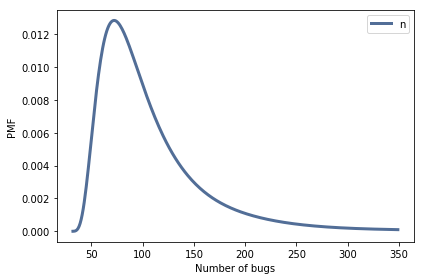

In [14]:
n_marginal = suite.Marginal(0)

print('post mean n', n_marginal.Mean())
print('MAP n', n_marginal.MaximumLikelihood())

thinkplot.Pdf(n_marginal, label='n')
thinkplot.decorate(xlabel='Number of bugs',
                   ylabel='PMF')

post mean p1 0.22994325572783006
MAP p1 0.2
post mean p2 0.17521894732003349
MAP p2 0.13333333333333333


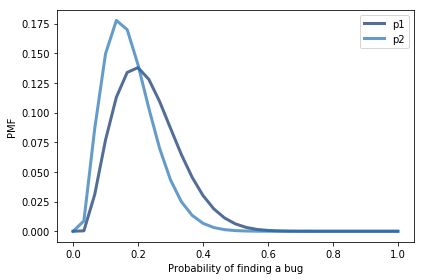

In [15]:
p1_marginal = suite.Marginal(1, label='p1')
p2_marginal = suite.Marginal(2, label='p2')

print('post mean p1', p1_marginal.Mean())
print('MAP p1', p1_marginal.MaximumLikelihood())

print('post mean p2', p2_marginal.Mean())
print('MAP p2', p2_marginal.MaximumLikelihood())

thinkplot.Pdf(p1_marginal)
thinkplot.Pdf(p2_marginal)

thinkplot.decorate(xlabel='Probability of finding a bug',
                   ylabel='PMF')